# Data Analysis on Walmart Dataset

## Neccesary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pickle

## Neccesary Functions 

### Filter Dataset

In [2]:
def filter_dataset(df,store,depts):
    df = df[(df['Store'] == store) & ((df['Dept'] == depts[0]) | (df['Dept'] == depts[1]) | (df['Dept'] == depts[2]))]
    return df

### High level information

In [3]:
def describe_df(df):
    print(f'Shape: {df.shape}')  
    print(f'\nColumn Names: {df.columns}')  
    print(f'\nData Types:')
    print(df.dtypes) 
    print(f'\nNon-Missing Values:')
    print(df.count()) 
    print(f'\nMissing Values:')
    print(df.isnull().sum()) 
    print(f'\nDistinct Values:')
    print(df.nunique())  
    print(f'\nSummary Statistics:')
    print(df.describe())

### Initial data preprocessing

In [4]:
def core_processing(df):
    df = df.sort_values(by=['Dept','Date'])
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    df['Next week'] = df.groupby(['Dept'])['Weekly_Sales'].shift(-1)
    df = df.dropna()
    return df

### Plot sales by department

In [5]:
def plot_sales_dept(df):
    grouped = df.groupby(["Dept", "Date"]).sum()
    sns.lineplot(x="Date", y="Weekly_Sales", hue="Dept", data=df)
    plt.gcf().autofmt_xdate()
    n = 90 # number of days between each tick
    plt.title('Sales by Department')
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=n))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.savefig('Exports/Sales_by_Department.pdf')

### Split departments on seperates datasets

In [6]:
def devide_dataset(depts,df):
    df_list = []
    for dept in depts:
        df_list.append(df.loc[df['Dept'] == dept].reset_index(drop=True))
    return df_list

### Find and replace outliers

In [7]:
def replace_outliers_zscore(df_list,depts):
    df_modified = []
    for i in range (0,len(df_list)):
        df = df_list[i]
        sales = df['Weekly_Sales']
        z_scores = (sales - sales.mean()) / sales.std()
        outliers = sales[(np.abs(z_scores) > 3)]
        df.loc[(np.abs(z_scores) > 3), 'Weekly_Sales'] = np.nan
        df['Weekly_Sales'].fillna(df['Weekly_Sales'].median(), inplace=True)
        print(f'Department {depts[i]} has {outliers.shape[0]} outliers!')
        print(f'{outliers.shape[0]} outliers in total, corresponding to {round(outliers.shape[0]*100/ (df.shape[0]),2)}% of the whole dataset\n')
        df_modified.append(df)
    return df_modified
    

### Plot seasonality, trend and other usefull informations

In [8]:
def plot_seasonality(df_list,period,titles):
    for i in range (0,len(df_list)):
        data=pd.DataFrame(df_list[i])
        result = seasonal_decompose(data['Weekly_Sales'], model='additive',period=period)
        fig = plt.figure()  
        fig = result.plot()
        fig.set_size_inches(15, 12)
        fig.suptitle(titles[i], fontsize=20)
        plt.savefig('Exports/Seasonality_'+str(titles[i])+'.pdf')

### Plot sales by the given feature (e.g. sales by month, sales by day, sales by fuel_Price)

In [9]:
def plot_by_feautures(df_list,feauture,titles):
    fig, axes = plt.subplots(3, figsize=(6,10))
    general_title= "Plot By: " + str(feauture)
    fig.suptitle(general_title)
    sns.boxplot(ax=axes[0], data=df_list[0], x=feauture, y='Weekly_Sales').set_title(titles[0])
    sns.boxplot(ax=axes[1], data=df_list[1], x=feauture, y='Weekly_Sales').set_title(titles[1])
    sns.boxplot(ax=axes[2], data=df_list[2], x=feauture, y='Weekly_Sales').set_title(titles[2])
    plt.savefig('Exports/Plot_By_'+str(feauture)+'.pdf')

### Check stationarity appling Dickey-Fuller test

In [10]:
def plot_test_stationarity(df_list,titles, window = 12, cutoff = 0.01):
    for i in range (0,len(df_list)):
        timeseries = df_list[i]['Weekly_Sales']
        title = titles[i]
        #Προσδιορισμός rolling statistics
        rolmean = timeseries.rolling(window).mean()
        rolstd = timeseries.rolling(window).std()
        #Plot rolling statistics:
        fig = plt.figure(figsize=(12, 8))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        title = 'Rolling Mean & Standard Deviation for: ' + str(title)
        plt.title(title)
        plt.show()
        #Εφαρμόζω Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
        #Εφαρμόζω τον τελικό έλεγχο για να κριθούν τα δεδομένα
        if pvalue < cutoff:
            print('p-value = %.4f. The series',title, 'is likely stationary.' % pvalue)
        else:
            print('p-value = %.4f. The series' ,title, 'is likely non-stationary.' % pvalue) 
        print(dfoutput)
    

### Save the object of dataframes as pickle file to be used on the next notebook

In [11]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Data analysis process

### Define neccesary variables

In [12]:
am = 126
store = (am%45) +1
depts = [1,2,5]
titles = ['Department_1','Department_2','Department_5']

### High level information

In [13]:
walmart = pd.read_csv('walmart_cleaned.csv',index_col=0)
walmart = filter_dataset(walmart,store,depts)
describe_df(walmart)
walmart = core_processing(walmart)

Shape: (429, 17)

Column Names: Index(['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Next week',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

Data Types:
Store             int64
Date             object
IsHoliday         int64
Dept              int64
Weekly_Sales    float64
Next week       float64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type              int64
Size              int64
dtype: object

Non-Missing Values:
Store           429
Date            429
IsHoliday       429
Dept            429
Weekly_Sales    429
Next week         0
Temperature     429
Fuel_Price      429
MarkDown1       429
MarkDown2       429
MarkDown3       429
MarkDown4       429
MarkDown5       429
CPI     

### Sales by department

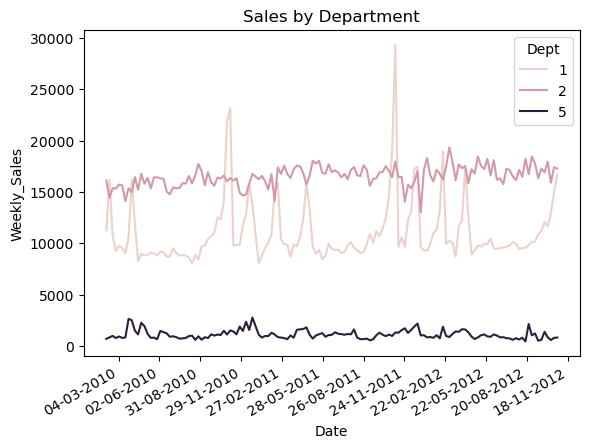

In [14]:
plot_sales_dept(walmart)

### Outliers Detection

In [15]:
walmart_obj = devide_dataset(depts,walmart)
walmart_obj = replace_outliers_zscore(walmart_obj,depts)

Department 1 has 3 outliers!
3 outliers in total, corresponding to 2.11% of the whole dataset

Department 2 has 1 outliers!
1 outliers in total, corresponding to 0.7% of the whole dataset

Department 5 has 3 outliers!
3 outliers in total, corresponding to 2.11% of the whole dataset



### Seasonality and Trends

<Figure size 640x480 with 0 Axes>

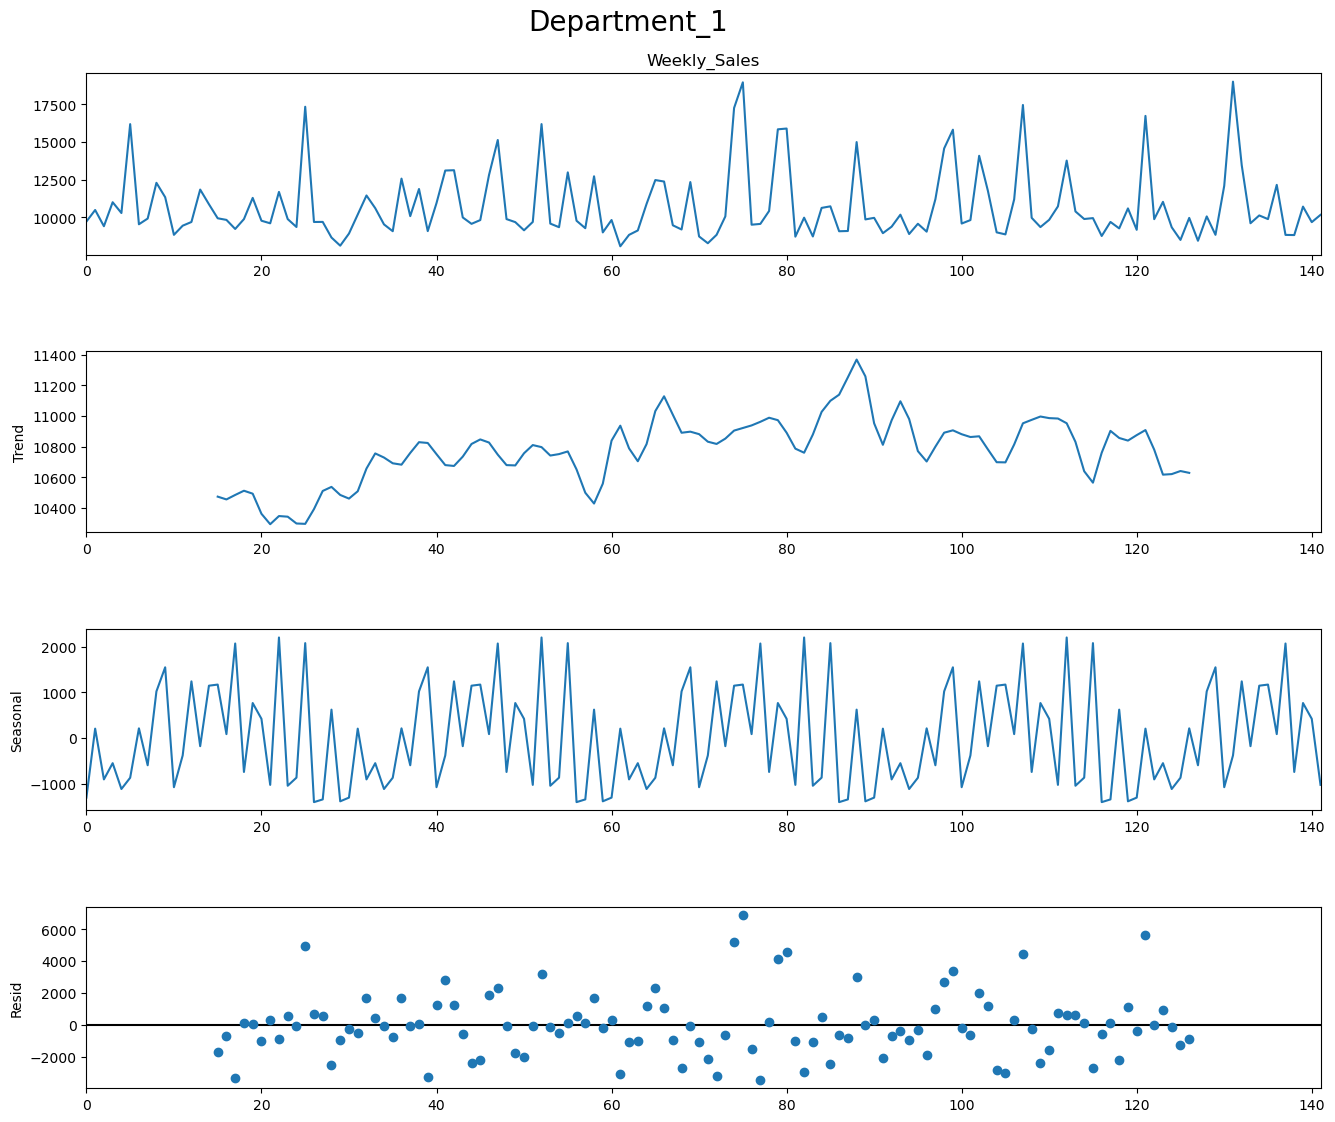

<Figure size 640x480 with 0 Axes>

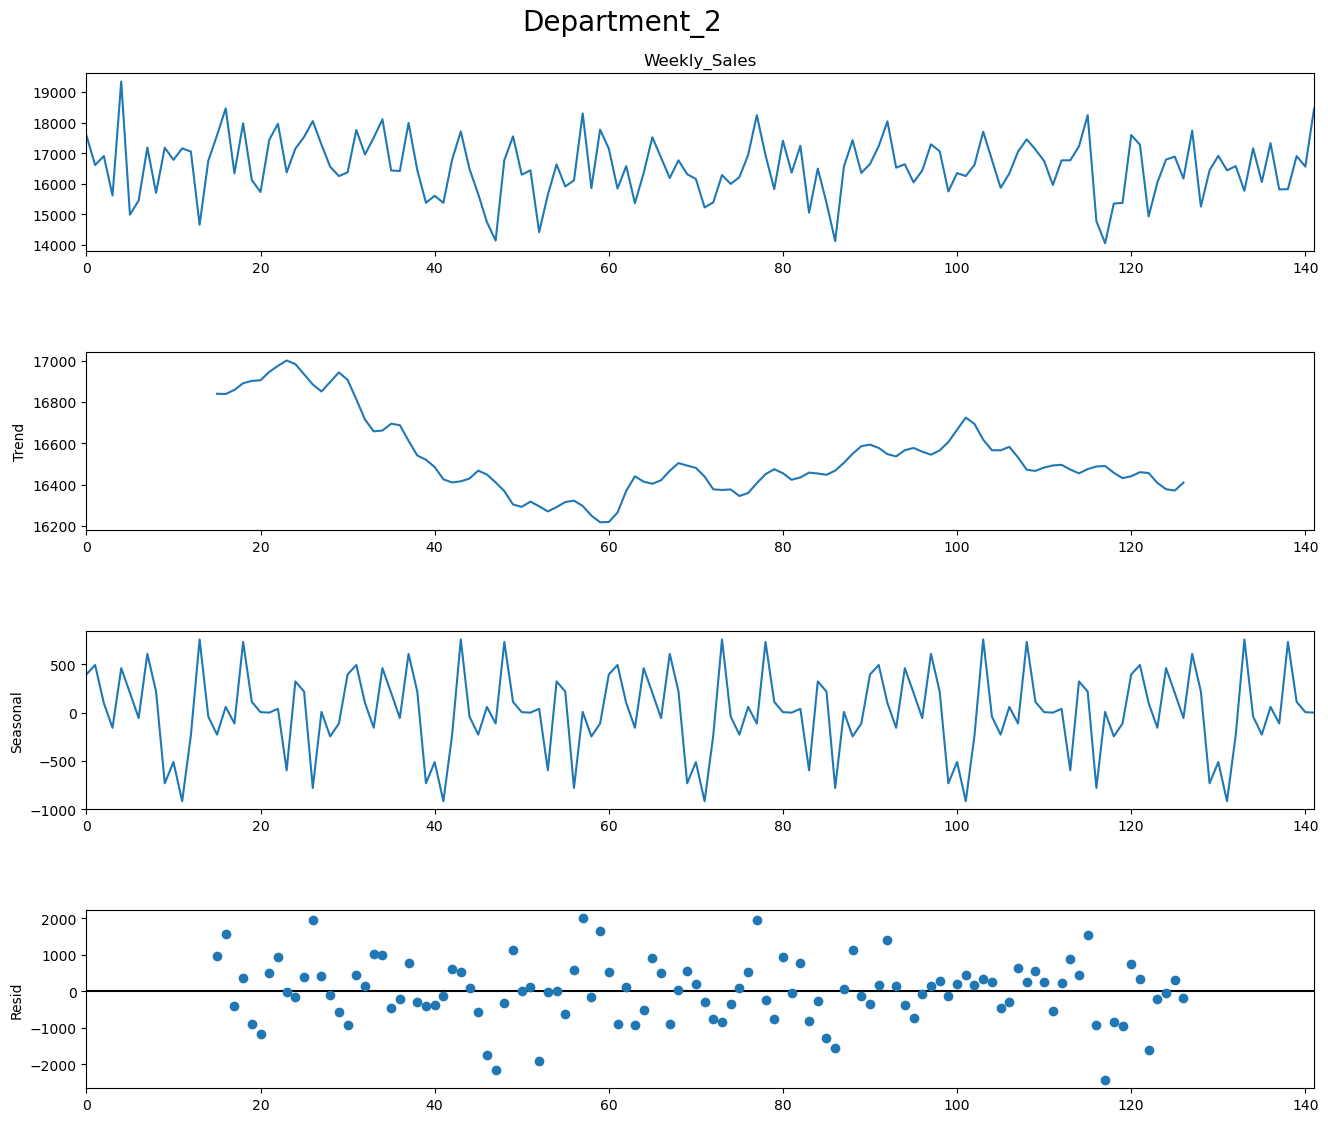

<Figure size 640x480 with 0 Axes>

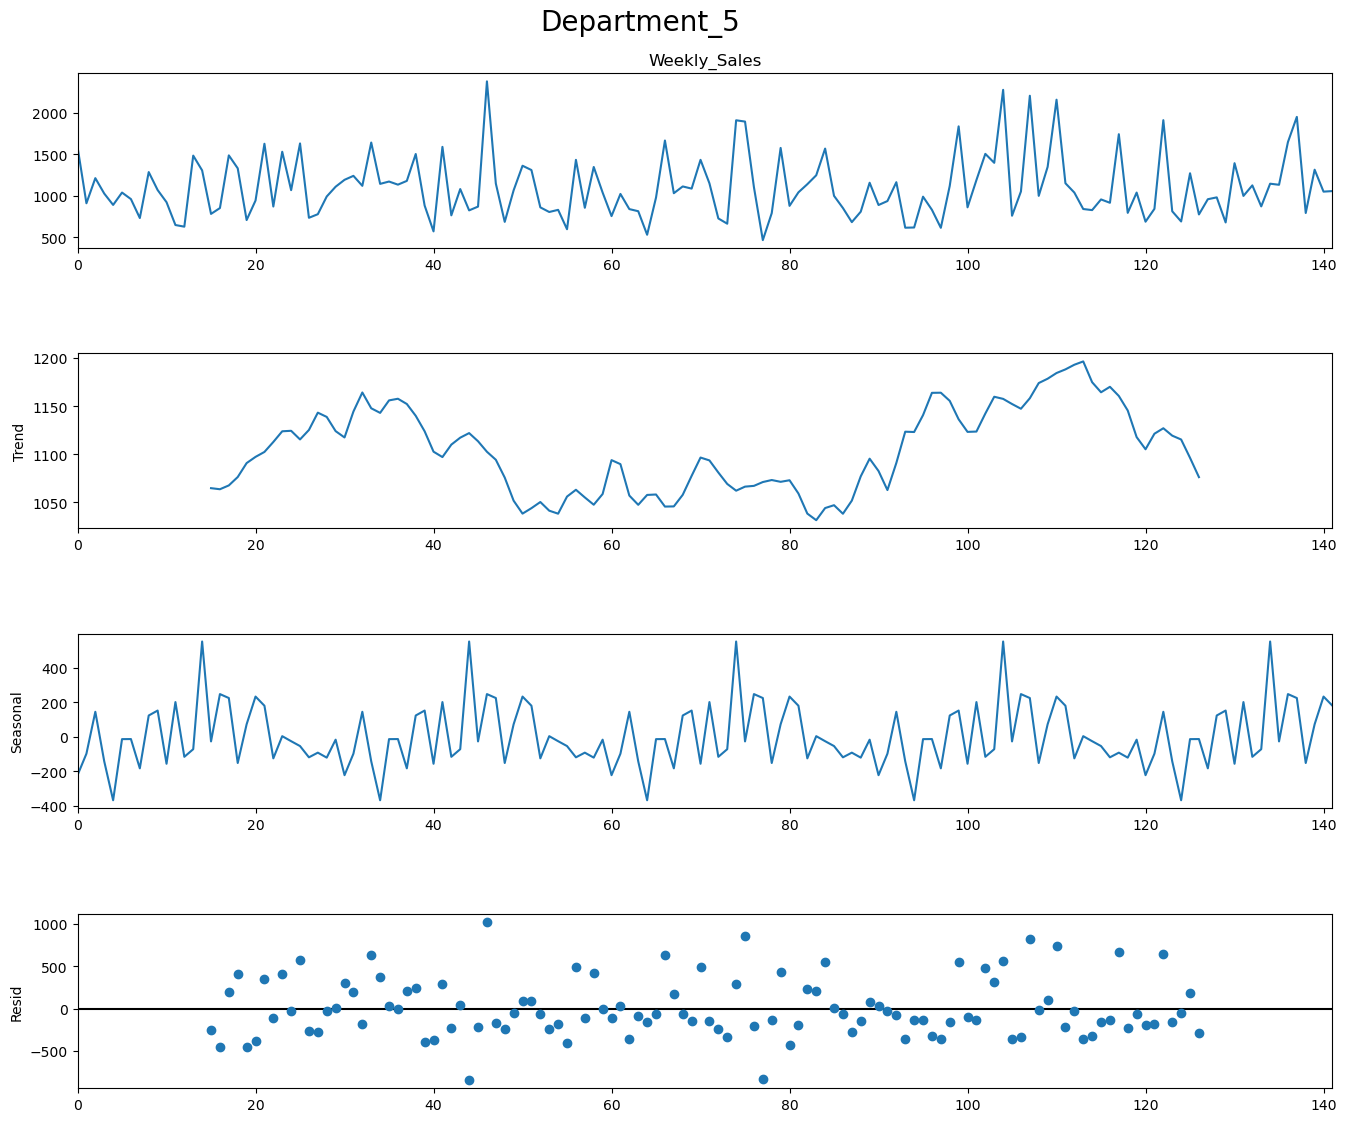

In [16]:
plot_seasonality(walmart_obj,30,titles)

### Sales by Week_of_Year

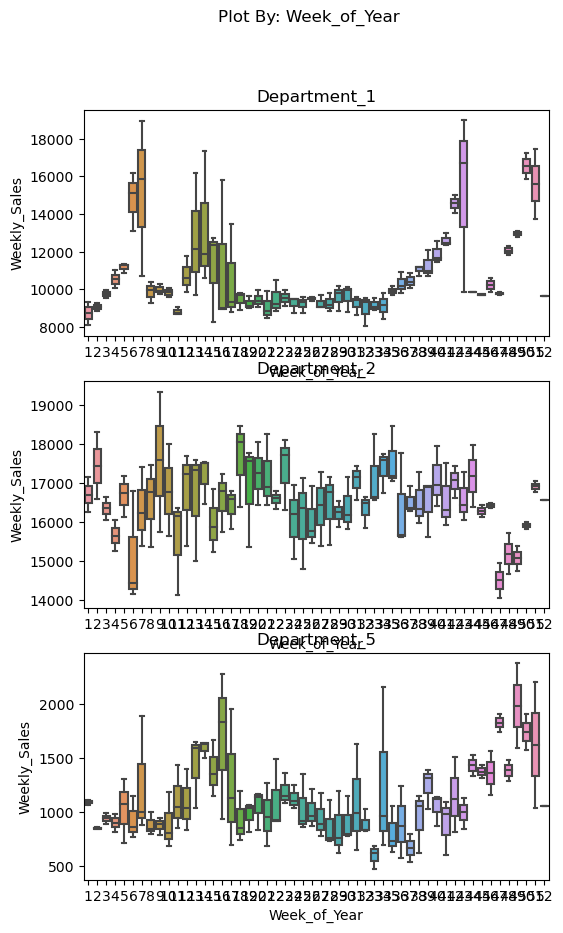

In [17]:
feauture = "Week_of_Year"
plot_by_feautures(walmart_obj,feauture,titles)

### Sales by Month

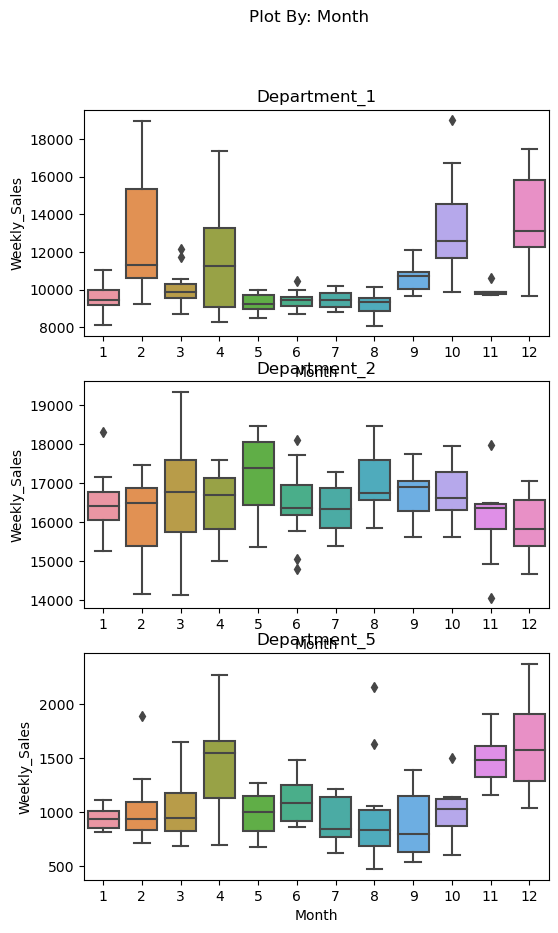

In [18]:
feauture = "Month"
plot_by_feautures(walmart_obj,feauture,titles)

### Sales by Unemployment

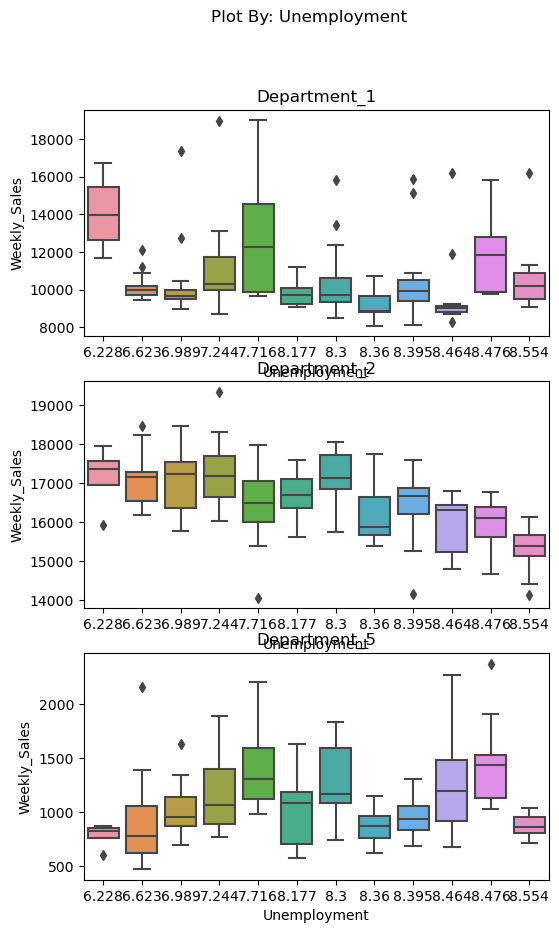

In [19]:
feauture = "Unemployment"
plot_by_feautures(walmart_obj,feauture,titles)

### Stationarity Test

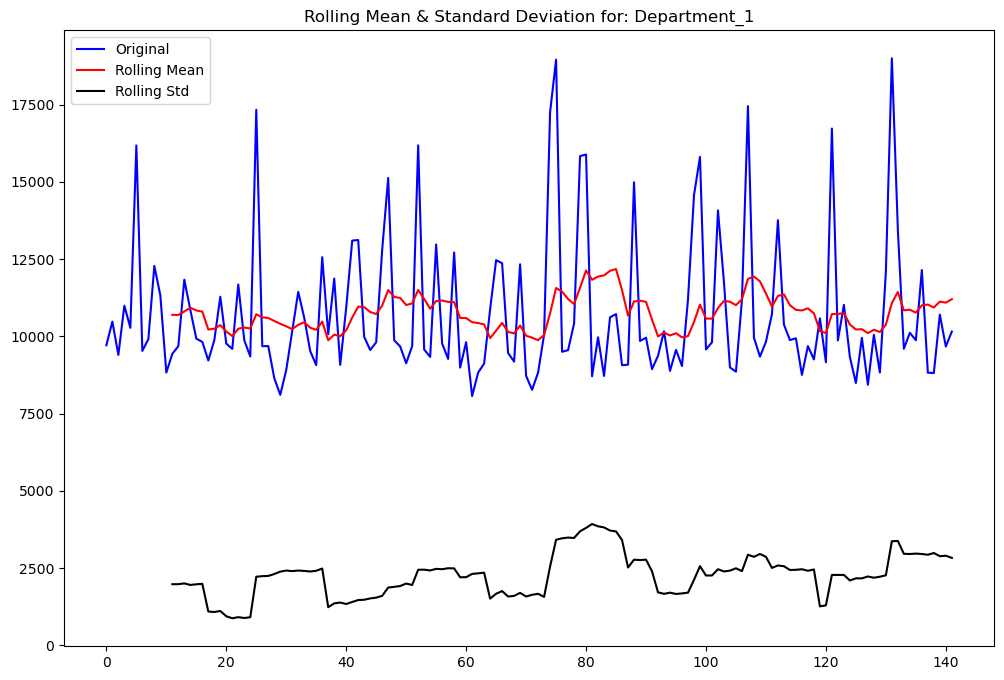

Results of Dickey-Fuller Test:
p-value = %.4f. The series Rolling Mean & Standard Deviation for: Department_1 is likely stationary.
Test Statistic                -5.806772e+00
p-value                        4.497435e-07
#Lags Used                     6.000000e+00
Number of Observations Used    1.350000e+02
Critical Value (1%)           -3.479743e+00
Critical Value (5%)           -2.883198e+00
Critical Value (10%)          -2.578320e+00
dtype: float64


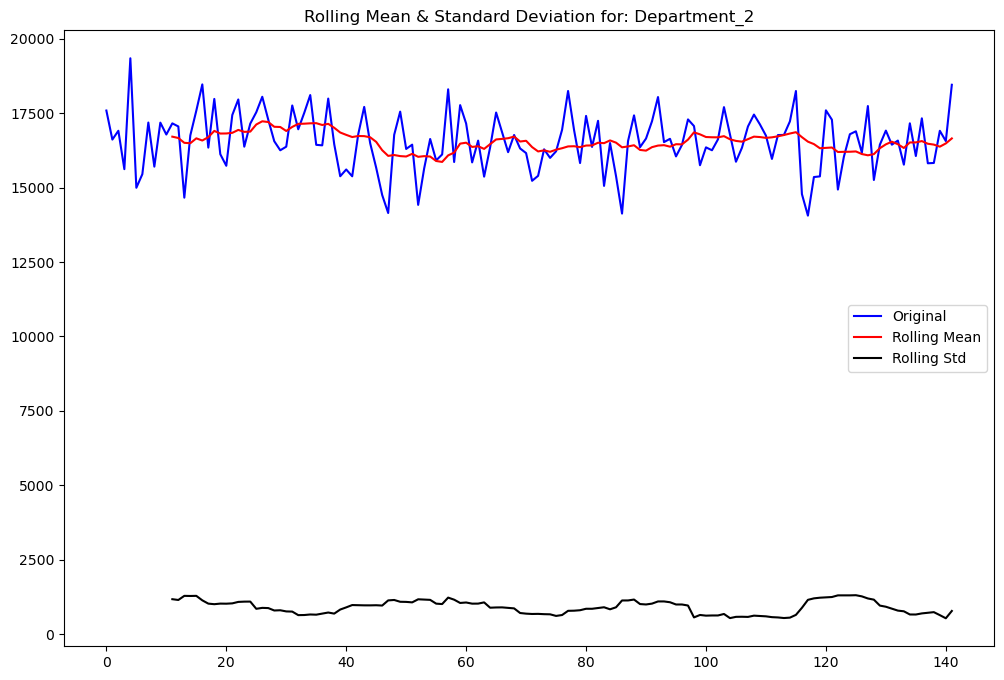

Results of Dickey-Fuller Test:
p-value = %.4f. The series Rolling Mean & Standard Deviation for: Department_2 is likely stationary.
Test Statistic                  -5.215102
p-value                          0.000008
#Lags Used                       4.000000
Number of Observations Used    137.000000
Critical Value (1%)             -3.479007
Critical Value (5%)             -2.882878
Critical Value (10%)            -2.578149
dtype: float64


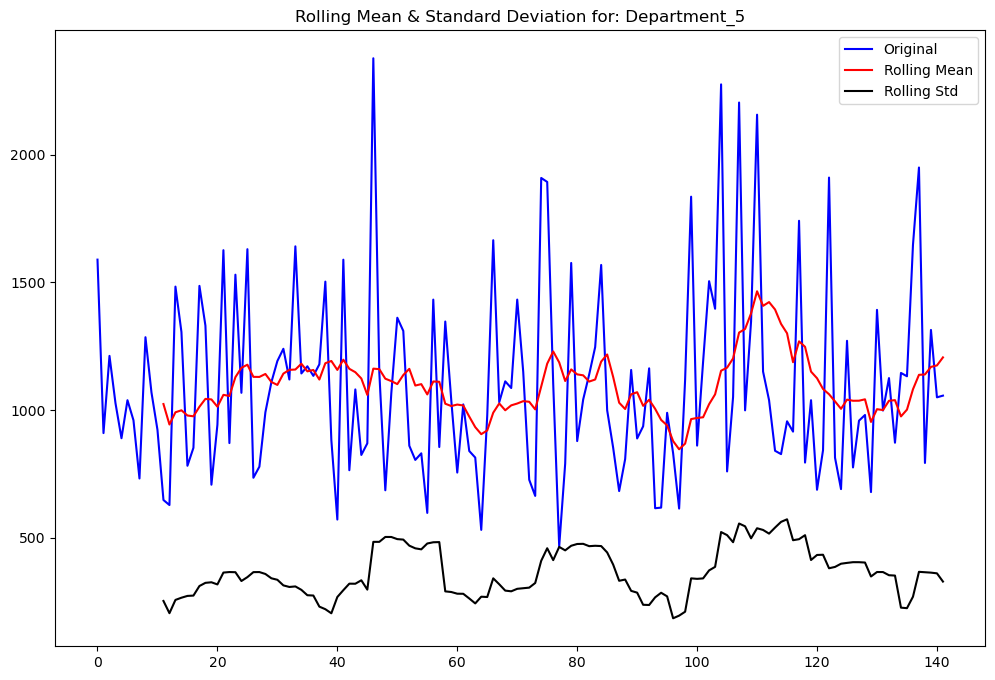

Results of Dickey-Fuller Test:
p-value = %.4f. The series Rolling Mean & Standard Deviation for: Department_5 is likely stationary.
Test Statistic                  -4.296292
p-value                          0.000451
#Lags Used                       5.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64


In [20]:
plot_test_stationarity(walmart_obj,titles, window = 12, cutoff = 0.01)

### Save the object of datasets

In [21]:
save_object(walmart_obj, 'dataset_object_v1.pkl')